# Computer Vision 이상치 탐지 알고리즘 경진대회

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('seaborn')
sns.set(font_scale = 1.5)
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from google.colab.patches import cv2_imshow
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

%matplotlib inline

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Study/Dacon/open/train_df.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Study/Dacon/open/test_df.csv')

In [4]:
df_train.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [40]:
# 라벨 종류 확인
df_train['label'].unique()

array(['transistor-good', 'capsule-good', 'wood-good', 'bottle-good',
       'screw-good', 'cable-bent_wire', 'carpet-hole', 'hazelnut-good',
       'pill-pill_type', 'cable-good', 'metal_nut-scratch', 'pill-good',
       'screw-thread_side', 'zipper-fabric_border', 'leather-good',
       'pill-scratch', 'toothbrush-good', 'hazelnut-crack',
       'screw-manipulated_front', 'zipper-good', 'tile-good',
       'carpet-good', 'metal_nut-good', 'bottle-contamination',
       'grid-good', 'zipper-split_teeth', 'pill-crack', 'wood-combined',
       'pill-color', 'screw-thread_top', 'cable-missing_cable',
       'capsule-squeeze', 'zipper-rough', 'capsule-crack', 'capsule-poke',
       'metal_nut-flip', 'carpet-metal_contamination', 'metal_nut-color',
       'transistor-bent_lead', 'zipper-fabric_interior', 'leather-fold',
       'tile-glue_strip', 'screw-scratch_neck', 'screw-scratch_head',
       'hazelnut-cut', 'bottle-broken_large', 'bottle-broken_small',
       'leather-cut', 'cable-cut_

In [43]:
# 라벨 종류 확인
print(len(df_train['label'].unique()))

88


In [5]:
# 클래스 종류가 몇가지 인지 확인
df_train['class'].unique()

array(['transistor', 'capsule', 'wood', 'bottle', 'screw', 'cable',
       'carpet', 'hazelnut', 'pill', 'metal_nut', 'zipper', 'leather',
       'toothbrush', 'tile', 'grid'], dtype=object)

In [6]:
# 상태 종류가 몇가지 인지 확인
df_train['state'].unique()

array(['good', 'bent_wire', 'hole', 'pill_type', 'scratch', 'thread_side',
       'fabric_border', 'crack', 'manipulated_front', 'contamination',
       'split_teeth', 'combined', 'color', 'thread_top', 'missing_cable',
       'squeeze', 'rough', 'poke', 'flip', 'metal_contamination',
       'bent_lead', 'fabric_interior', 'fold', 'glue_strip',
       'scratch_neck', 'scratch_head', 'cut', 'broken_large',
       'broken_small', 'cut_outer_insulation', 'squeezed_teeth',
       'defective', 'cut_inner_insulation', 'missing_wire', 'thread',
       'broken', 'faulty_imprint', 'glue', 'damaged_case', 'gray_stroke',
       'bent', 'print', 'broken_teeth', 'oil', 'misplaced', 'cable_swap',
       'poke_insulation', 'cut_lead', 'liquid'], dtype=object)

train 데이터는 4277개의 데이터  
test 데이터는 2154개의 데이터를 가지고 있다.  

---

종류도 꽤나 많으며 Label이 단순하게 class + state의 합으로 이뤄진 컬럼인걸 볼 수 있다.<br> 때문에 이후 EDA 과정에서 라벨은 제거해도 괜찮을 것 같다.

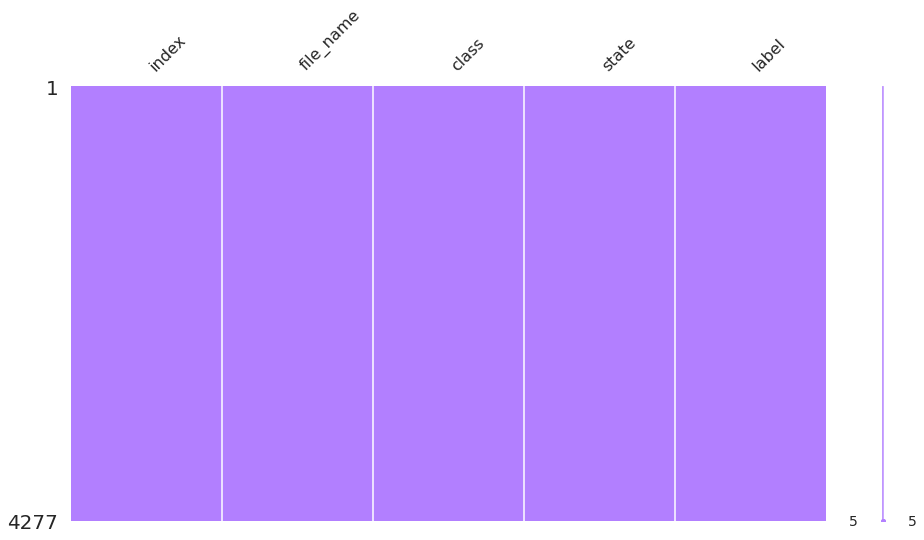

In [7]:
msno.matrix(df=df_train.iloc[:,:],figsize=(15,8), color=(0.7,0.5,1))

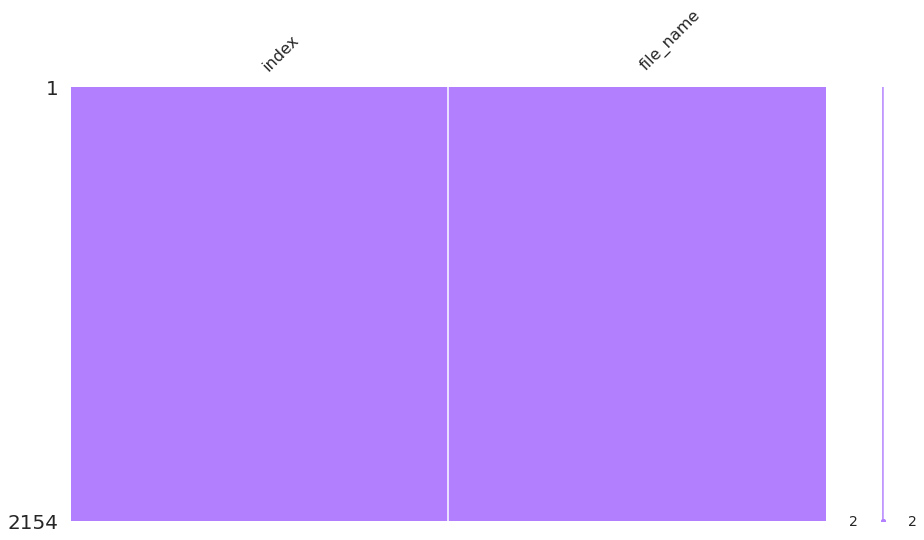

In [8]:
msno.matrix(df=df_test.iloc[:,:],figsize=(15,8), color=(0.7,0.5,1))

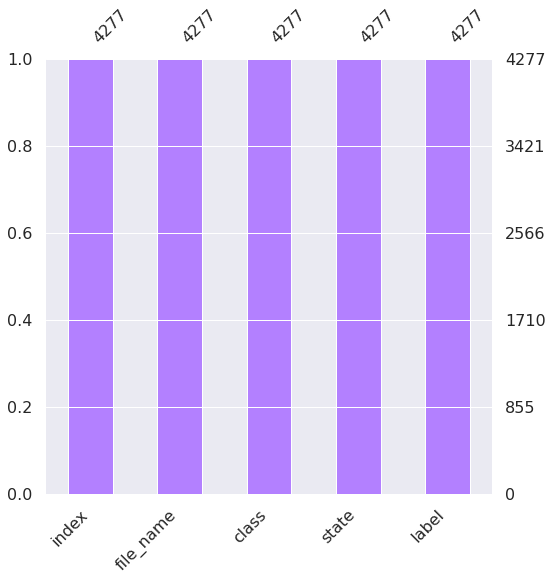

In [9]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.7, 0.5, 1))

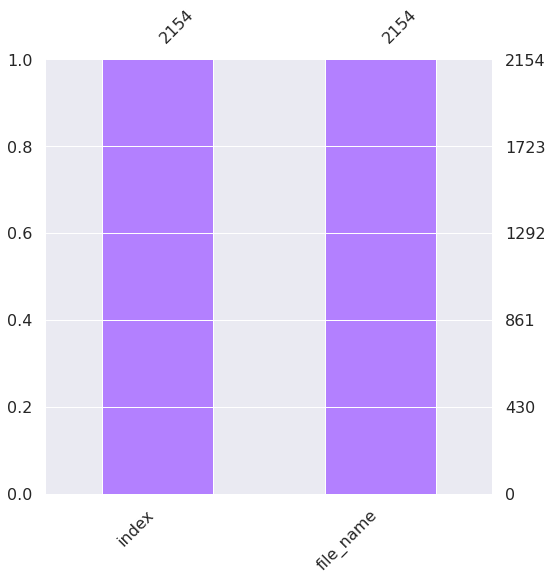

In [10]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.7, 0.5, 1))

각 feature에 null 값이 없음을 확인할 수 있다.

No handles with labels found to put in legend.


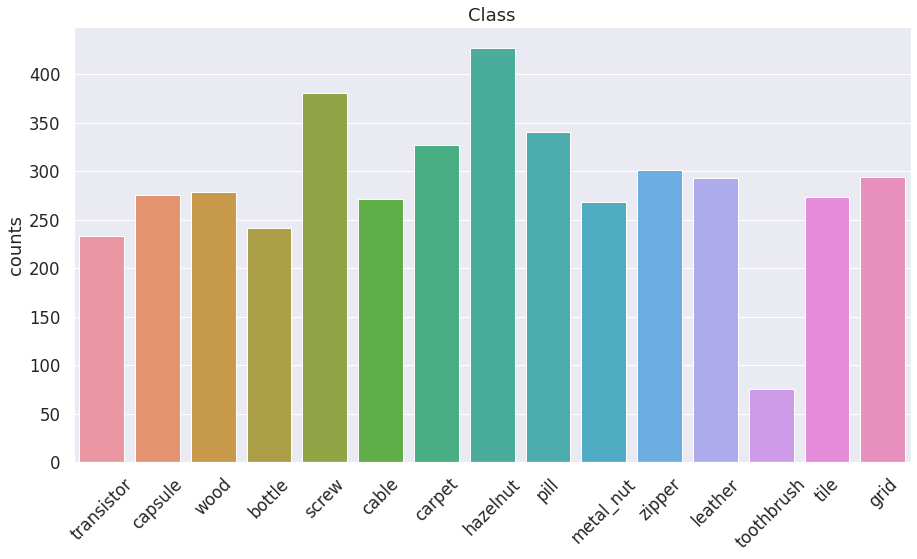

In [11]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1, 1,1)

plt.title('Class')
sns.countplot('class', data=df_train, ax=ax)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.xlabel('')
plt.ylabel('counts')
plt.legend()
plt.show()

다른 데이터에 비해서 toothbrush 데이터가 많이 부족한걸 볼 수 있는데 이로 인해서 나중에 훈련과정에서 제대로된 훈련이 안될 가능성이 높다.<br> 때문에 augmentation을 이용해서 toothbrush 데이터를 대략 200개 까지 만들 생각이다.

No handles with labels found to put in legend.


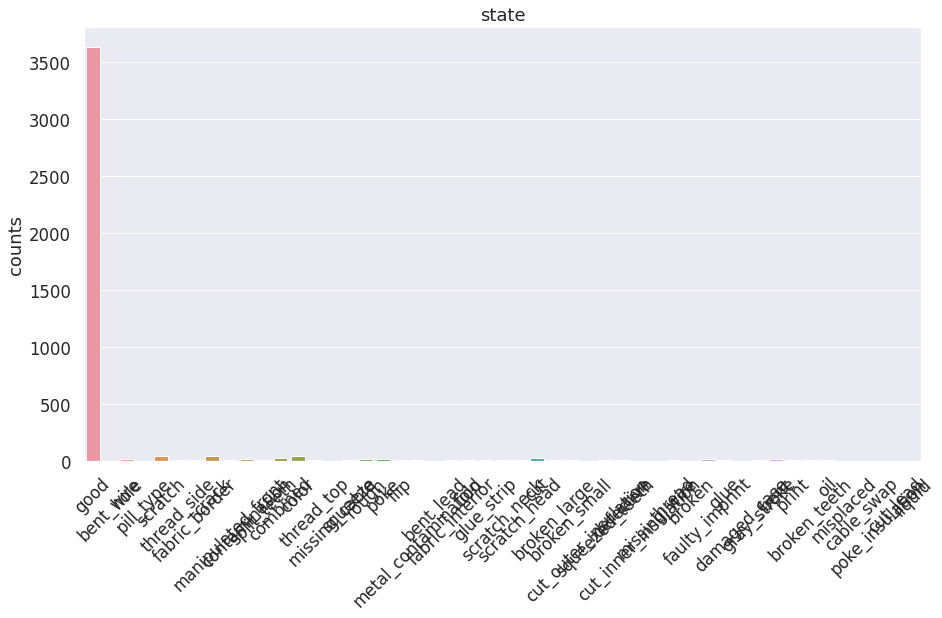

In [12]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1, 1,1)

plt.title('state')
sns.countplot('state', data=df_train, ax=ax)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.xlabel('')
plt.ylabel('counts')
plt.legend()
plt.show()

양품인 경우가 너무 많아서 양품일 경우를 제외하고 새로 데이터를 비교할 필요가 있다.<br>또한 데이터 비율이 너무 크게 차이나서 훈련이 제대로 안이뤄 질것이다.
<br>그렇기 때문에 augmentation을 통해 다른 데이터를 늘려줄 필요가 있다!

In [13]:
is_broken = df_train['state'] !='good'

In [14]:
broken = df_train[is_broken]

In [15]:
broken

,index,file_name,class,state,label
8,8,10008.png,cable,bent_wire,cable-bent_wire
10,10,10010.png,carpet,hole,carpet-hole
13,13,10013.png,pill,pill_type,pill-pill_type
16,16,10016.png,metal_nut,scratch,metal_nut-scratch
19,19,10019.png,screw,thread_side,screw-thread_side
...,...,...,...,...,...
4245,4245,14245.png,leather,cut,leather-cut
4248,4248,14248.png,transistor,bent_lead,transistor-bent_lead
4251,4251,14251.png,cable,combined,cable-combined
4252,4252,14252.png,pill,color,pill-color


No handles with labels found to put in legend.


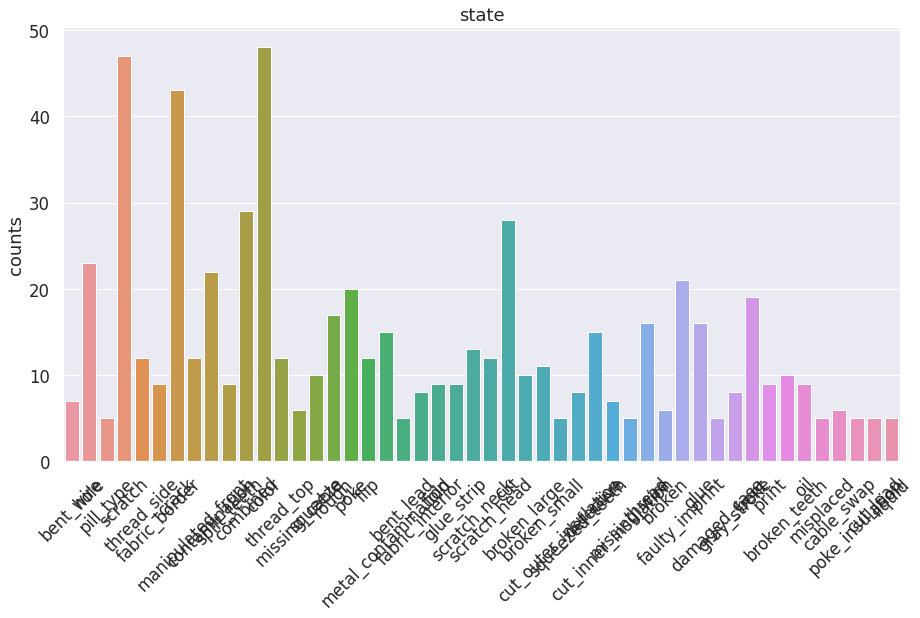

In [17]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1, 1,1)

plt.title('state')
sns.countplot('state', data=broken, ax=ax)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)

plt.xlabel('')
plt.ylabel('counts')
plt.legend()
plt.show()

In [18]:
# trainset 불러오기
trainimg = glob.glob('/content/drive/MyDrive/Study/Dacon/train/*_resize.png')

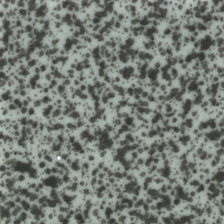

In [19]:
img = cv2.imread(trainimg[0], cv2.IMREAD_COLOR)
cv2_imshow(img)

In [20]:
print(img.shape)

(224, 224, 3)


In [21]:
print(len(trainimg))

4277


In [23]:
broken[['index']]

,index
8,8
10,10
13,13
16,16
19,19
...,...
4245,4245
4248,4248
4251,4251
4252,4252


In [24]:
try:
    if broken['index'][0]:
        print('yes')
except:
    print('no')

no


In [26]:
resize_trainimg = glob.glob('/content/drive/MyDrive/Study/Dacon/train/*_resize.png')

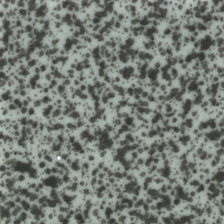

In [27]:
img = cv2.imread(resize_trainimg[0], cv2.IMREAD_COLOR)
cv2_imshow(img)

In [28]:
print(img.shape)

(224, 224, 3)


In [32]:
data_dir = '/content/drive/MyDrive/Study/Dacon/train'

In [36]:
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*'))

In [37]:
for f in list_ds.take(5):
    print(f.numpy())

b'/content/drive/MyDrive/Study/Dacon/train/10868.png'
b'/content/drive/MyDrive/Study/Dacon/train/13053_resize.png'
b'/content/drive/MyDrive/Study/Dacon/train/10553.png'
b'/content/drive/MyDrive/Study/Dacon/train/11230_resize.png'
b'/content/drive/MyDrive/Study/Dacon/train/12442.png'


In [ ]:
def get_label(file_path):
  # 경로를 경로 구성요소 목록으로 변환합니다
  parts = tf.strings.split(file_path, os.path.sep)
  # 끝에서 두 번째 요소는 클래스 디렉터리입니다.
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # 압축된 문자열을 3D uint8 텐서로 변환합니다
  img = tf.image.decode_jpeg(img, channels=3)
  # `convert_image_dtype`은0~1 사이의 float 값으로 변환해줍니다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 이미지를 원하는 크기로 조정합니다.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # 파일에서 raw 데이터를 문자열로 불러옵니다
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label